In [358]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from numpy import linalg as LA
import time
import timeit

# Problem1

In [359]:
df=pd.read_csv('DailyReturn.csv')

In [360]:
def populateWeights(x, w, cw, λ):
    n = len(x)
    tw = 0.0
    for i in range(n):
        x[i] = i+1
        w[i] = (1-λ)*(λ**i)
        tw += w[i]
        cw[i] = tw
    for i in range(n):
        w[i] = w[i]/tw
        cw[i] = cw[i]/tw

def exw(cw, data):
    stock_names = list(data.columns)
    stock_names.pop(0)
    
    mat = np.empty((len(stock_names),len(stock_names)))
    cov_mat = pd.DataFrame(mat, columns = stock_names, index = stock_names)
    
    
    for i in range(len(stock_names)):
        for j in range(len(stock_names)):
            x_data=data.iloc[:, i+1].tolist()
            y_data=data.iloc[:, j+1].tolist()
            x_mean=sum(x_data)/len(x_data)
            y_mean=sum(y_data)/len(y_data)
            
            s=0       
            for m in range(len(data['SPY'].tolist())):
                s += cw[m]*(x_data[m] - x_mean)*(y_data[m] - y_mean)
            cov_mat.iloc[i, j]=s
    return cov_mat



In [362]:
lamda=0.97
n=len(df['SPY'].tolist())
x=np.empty(n)
w=np.empty(n)
cw=np.empty(n)
populateWeights(x, w, cw, lamda)
cov_mat=exw(cw, df)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


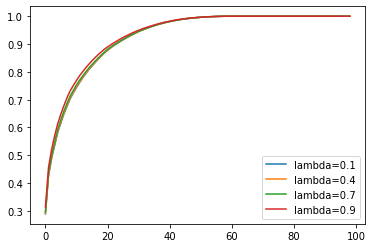

In [363]:
def simulate_pca(a, nsim, nval=None):
    vals, vecs = np.linalg.eig(a)
    idx = np.argsort(-vals)
    vals = vals[idx]
    vecs = vecs[:, idx]
    posv = np.where(vals >= 1e-8)[0]
    if nval is not None:
        if nval < len(posv):
            posv = posv[:nval]
    vals = vals[posv]
    vecs = vecs[:, posv]
    cum_var = (np.cumsum(vals[:nsim]) / np.sum(vals))[-1]

    return cum_var

lambda_values = [0.1, 0.4, 0.7, 0.9]
#plt.figure(figsize=(10, 6))
for lambda_ in lambda_values:
    n=len(df['SPY'].tolist())
    x=np.empty(n)
    w=np.empty(n)
    cw=np.empty(n)
    populateWeights(x, w, cw, lambda_)
    cov_matrix = exw(cw, df)
    cum_vars=[]
    for i in range(1, 100):
        cum_vars.append(simulate_pca(cov_matrix, i))
    plt.plot(cum_vars, label=f"lambda={lambda_}")
plt.legend()
plt.show()

# Problem2

In [364]:
def chol_psd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        temp = a[j, j] - s
        if temp <= 0:
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        if root[j, j] == 0.0:
            root[j, j+1:] = 0.0
        else:
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    return root

In [365]:
def project_positive(A, W=None):
    """
    Project a matrix onto the positive semi-definite cone.
    """
    if W is None:
        W = np.eye(A.shape[0])
    d, V = LA.eigh(A)
    d[d < 0] = 0
    return V @ np.diag(d) @ V.T

def project_unitary(A, W=None):
    """
    Project a matrix onto the unitary cone.
    """
    if W is None:
        W = np.eye(A.shape[0])
    return W @ A @ W

def higham_psd(C, W=None, max_iterations=100, tol=1e-6):
    """
    Find the nearest PSD correlation matrix to C using Higham's (2002) algorithm.
    """
    A = C.copy()
    S = np.zeros(A.shape)
    delta_S = np.zeros(A.shape)
    Y = np.zeros(A.shape)
    for k in range(max_iterations):
        R = A - delta_S
        X = project_positive(R, W)
        delta_S = X - R
        Y = project_unitary(X, W)
        if LA.norm(Y - A) < tol:
            break
        A = Y.copy()
    return A

In [366]:
def near_psd(a, epsilon=0.0):
    n = a.shape[0]

    invSD = None
    out = a.copy()

    # calculate the correlation matrix if we got a covariance
    if np.count_nonzero(np.diag(out) == 1.0) != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = np.matmul(np.matmul(invSD, out), invSD)

    # SVD, update the eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.reciprocal(np.matmul(np.square(vecs), vals))
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T

    #Add back the variance
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = invSD @ out @ invSD
    return out

In [368]:
n=500
sigma=np.full((n,n), 0.9)
np.fill_diagonal(sigma, 1.0)

sigma[1,2]=0.7357
sigma[2,1]=0.7357
sigma

array([[1.    , 0.9   , 0.9   , ..., 0.9   , 0.9   , 0.9   ],
       [0.9   , 1.    , 0.7357, ..., 0.9   , 0.9   , 0.9   ],
       [0.9   , 0.7357, 1.    , ..., 0.9   , 0.9   , 0.9   ],
       ...,
       [0.9   , 0.9   , 0.9   , ..., 1.    , 0.9   , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 1.    , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 0.9   , 1.    ]])

In [369]:
chol=chol_psd(sigma)
higham=higham_psd(sigma)
near=near_psd(sigma)

In [370]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > -1e-8)
print(is_pos_def(sigma))
print(is_pos_def(higham))
print(is_pos_def(near))

False
True
True


In [371]:
frobenius_higham = np.linalg.norm(sigma - higham, 'fro')
frobenius_near=np.linalg.norm(sigma - near, 'fro')
print(frobenius_higham)
print(frobenius_near)

0.06364303890468953
0.6275226557619892


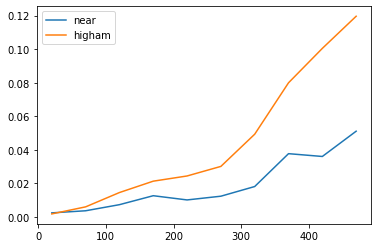

In [372]:
near_time=[]
high_time=[]
N=np.arange(20, 501, 50)

for n in N:
    sigma1=sigma[:n, :n]
    
    start = time.time()
    near_psd(sigma1) # This is the task which I have done
    end = time.time()
    near_time.append((end - start))

    start = time.time()
    higham_psd(sigma1) # This is the task which I have done
    end = time.time()
    high_time.append((end - start))
#print(near_time)
#print(high_time)
plt.plot(N, near_time, label="near")
plt.plot(N, high_time, label="higham")
plt.legend()
plt.show()

# Problem3

In [373]:
df=pd.read_csv('DailyReturn.csv')

In [374]:
def simulate_multivariate_normal(mean, covariance, num_samples, use_pca=False, explained_variance=None):
    if use_pca:
        if explained_variance is None:
            explained_variance = 100
        elif not (0 <= explained_variance <= 100):
            raise ValueError("Percentage of explained variance must be between 0 and 100.")
            
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        explained_variance_ratio = eigenvalues / eigenvalues.sum()
        explained_variance_ratio = explained_variance_ratio.cumsum()
        num_components = np.argmax(explained_variance_ratio >= explained_variance/100) + 1
        eigenvectors = eigenvectors[:, :num_components]
        covariance = eigenvectors.dot(np.diag(eigenvalues[:num_components]).dot(eigenvectors.T))
        
    lower_triangular_matrix = chol_psd(covariance)
    normal_samples = np.random.normal(size=(mean.shape[0], num_samples))
    samples = mean + lower_triangular_matrix.dot(normal_samples)
    
    return samples.T

In [377]:
correlation = np.corrcoef(df.drop('Unnamed: 0', axis=1), rowvar=False)
variance = np.var(df.drop('Unnamed: 0', axis=1), axis=0)

In [378]:
n=len(df['SPY'].tolist())
x=np.empty(n)
w=np.empty(n)
cw=np.empty(n)
populateWeights(x, w, cw, lamda)
cov_mat=exw(cw, df)
ew_correlation=cov_mat.corr().values
ew_variance=cov_mat.var().values

In [379]:
# 1
#pearson_covariance = np.diag(variance).dot(correlation)
a=df.drop('Unnamed: 0', axis=1)
pearson_covariance = np.cov(a, rowvar=False)

In [380]:
# 2
ew_covariance = np.diag(ew_variance).dot(ew_correlation)

In [381]:
# 3
lamda=0.97
n=len(df['SPY'].tolist())
x=np.empty(n)
w=np.empty(n)
cw=np.empty(n)
populateWeights(x, w, cw, lamda)
cov_mat=np.array(exw(cw, df))

In [382]:
# 4
def four(df, lambda_=0.97):
    df1=df.drop('Unnamed: 0', axis=1)
    cov = cov_mat  
    asset_std = np.diag(np.reciprocal(np.sqrt(np.diag(cov))))
    corr = asset_std @ cov @ asset_std.T
    var = np.var(df1)
    std_dev = np.sqrt(var)
    cov = np.outer(std_dev, std_dev) * corr
    return cov

ew_corr_p_var = four(df)

In [383]:
mean=np.zeros((101, 1))

def run_time_4(cov):
    v=[100, 75, 50]
    t=[]
    fb=[]
    
    start_time = time.time()
    samples = simulate_multivariate_normal(mean, cov, 25000, False, None)
    time_used = time.time() - start_time
    t.append(time_used)
    simulated_covariance = np.cov(samples, rowvar=False)
    fb.append(np.linalg.norm(simulated_covariance - cov, 'fro'))
    
    for n in v:
        start_time = time.time()
        samples = simulate_multivariate_normal(mean, cov, 25000, True, n)
        time_used = time.time() - start_time
        t.append(time_used)
        simulated_covariance = np.cov(samples, rowvar=False)
        fb.append(np.linalg.norm(simulated_covariance - cov, 'fro'))
    return t,fb

In [384]:
t,fb=run_time_4(pearson_covariance)
print('Direct time: {} Frobenius Norm: {}'.format(t[0], fb[0]))
print('PCA 1.0: {} Frobenius Norm: {}'.format(t[1], fb[1]))
print('PCA 0.75: {} Frobenius Norm: {}'.format(t[2], fb[2]))
print('PCA 0.5: {} Frobenius Norm: {}'.format(t[3], fb[3]))


<ipython-input-364-9f5319455bcc>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  root[j, j] = np.sqrt(temp)
<ipython-input-364-9f5319455bcc>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  root[i, j] = (a[i, j] - s) * ir


Direct time: 0.14380192756652832 Frobenius Norm: 0.000253999441525778
PCA 1.0: 0.09244012832641602 Frobenius Norm: 0.006449095896888769
PCA 0.75: 0.09148216247558594 Frobenius Norm: 0.0016457901826718894
PCA 0.5: 0.08663797378540039 Frobenius Norm: 0.0033396542741153455


In [385]:
t,fb=run_time_4(ew_covariance)
print('Direct time: {} Frobenius Norm: {}'.format(t[0], fb[0]))
print('PCA 1.0: {} Frobenius Norm: {}'.format(t[1], fb[1]))
print('PCA 0.75: {} Frobenius Norm: {}'.format(t[2], fb[2]))
print('PCA 0.5: {} Frobenius Norm: {}'.format(t[3], fb[3]))

<ipython-input-364-9f5319455bcc>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  root[j, j] = np.sqrt(temp)
<ipython-input-364-9f5319455bcc>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  root[i, j] = (a[i, j] - s) * ir


Direct time: 0.1178741455078125 Frobenius Norm: 0.8674261065085048
PCA 1.0: 0.10222578048706055 Frobenius Norm: 0.00104294765581314
PCA 0.75: 0.0933692455291748 Frobenius Norm: 0.0010315530276428539
PCA 0.5: 0.09413003921508789 Frobenius Norm: 0.0010882147479793416


In [386]:
t,fb=run_time_4(cov_mat)
print('Direct time: {} Frobenius Norm: {}'.format(t[0], fb[0]))
print('PCA 1.0: {} Frobenius Norm: {}'.format(t[1], fb[1]))
print('PCA 0.75: {} Frobenius Norm: {}'.format(t[2], fb[2]))
print('PCA 0.5: {} Frobenius Norm: {}'.format(t[3], fb[3]))

<ipython-input-364-9f5319455bcc>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  root[j, j] = np.sqrt(temp)
<ipython-input-364-9f5319455bcc>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  root[i, j] = (a[i, j] - s) * ir


Direct time: 0.1218869686126709 Frobenius Norm: 0.008748666125820866
PCA 1.0: 0.09900188446044922 Frobenius Norm: 0.00731800046011233
PCA 0.75: 0.08974790573120117 Frobenius Norm: 0.06764534004270853
PCA 0.5: 0.08454489707946777 Frobenius Norm: 0.138062725129939


In [387]:
t,fb=run_time_4(ew_corr_p_var)
print('Direct time: {} Frobenius Norm: {}'.format(t[0], fb[0]))
print('PCA 1.0: {} Frobenius Norm: {}'.format(t[1], fb[1]))
print('PCA 0.75: {} Frobenius Norm: {}'.format(t[2], fb[2]))
print('PCA 0.5: {} Frobenius Norm: {}'.format(t[3], fb[3]))

<ipython-input-364-9f5319455bcc>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  root[j, j] = np.sqrt(temp)
<ipython-input-364-9f5319455bcc>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  root[i, j] = (a[i, j] - s) * ir


Direct time: 0.12064003944396973 Frobenius Norm: 0.00019022981826616932
PCA 1.0: 0.09585976600646973 Frobenius Norm: 0.00020651625684188786
PCA 0.75: 0.09497499465942383 Frobenius Norm: 0.0016176736904649884
PCA 0.5: 0.09337615966796875 Frobenius Norm: 0.0034650256727319726
